# Stereochemistry and reactivity

[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)

Stereoisomers can generally be of two types: *disastereoisomers* (also called diastereomers) and *enantiomers*. Enantiomers are mirror images of each other and therefore exist in pairs. Each specific stereoisomer can have only one enantiomer. Enantiomers have the same chemical properties except when interacting with a chiral environment (such as an enzyme, or chiral catalyst). Enantiomers can be formed via *enantiomeric transition states*, which are mirror images of each other. Diastereomers are formed via *diasteromeric transition states*. This leads to a couple of considerations when modelling reactivity of molecules which have multiple stereoisomers:

1. Reactions which form enantiomers will have the same activation energy in a non-chiral environment. We therefore only need to calculate one of them.
2. Reactions which form diasterioisomers will have different activation energies.
3. Reaction starting from different diastereoisomers will likely have different activation energies.

We will investigate this in relation to one of the most simple Diels-Alder reactions, that between cyclopentadiene and maleic anhydride. We start by drawing the starting materials, which are achiral, together with the product without specified chirality

In [1]:
# Importing things
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addStereoAnnotation = True

from polanyi.io import get_xyz_string
from polanyi.xtb import opt_xtb, XTBCalculator
from polanyi.workflow import opt_constrained_complex, opt_ts_python
from polanyi.interpolation import interpolate_geodesic
from polanyi.data import HARTREE_TO_KCAL

import py3Dmol

In [2]:
# Function for displaying molecules in py3Dmol
def view_py3Dmol(elements, coordinates, width=300, height=300, scale=0.3, show_indices=False):
    view = py3Dmol.view(width=width, height=height)
    view.addModel(get_xyz_string(elements, coordinates), "xyz")
    view.setStyle({'sphere': {"scale": scale}, 'stick':{}})
    if show_indices == True:
        view.addPropertyLabels("index", True, {"fontColor": "black", "showBackground": False, "alignment": "center"})
    return view

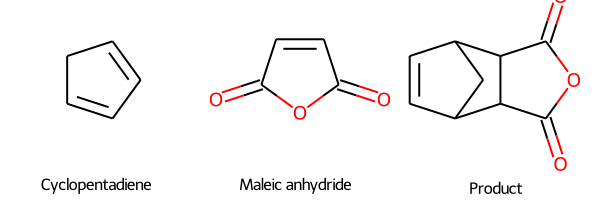

In [3]:
# Creating mol objects for reactants and products
smiles_de = "C1=CCC=C1"
smiles_dp = "O=C(C=C1)OC1=O"
smiles_p = "O=C1OC(C2C3C=CC(C3)C21)=O"
mol_de = Chem.MolFromSmiles(smiles_de)
mol_dp = Chem.MolFromSmiles(smiles_dp)
mol_p = Chem.MolFromSmiles(smiles_p)
Chem.Draw.MolsToGridImage([mol_de, mol_dp, mol_p], legends=["Cyclopentadiene", "Maleic anhydride", "Product"], molsPerRow=3)

In fact, four new stereocenters are formed during the reaction, and due to the stereospecificity of the Diels-Alder reaction, we can either the "exo" or the "endo" form of the product. They actualy differ in the configuration of two out of four stereocenters, and are therefore diastereomers. We therefore expect them to show different activation energies for formation via diasteromeric transition states.

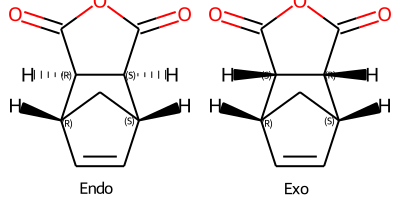

In [4]:
# Creating mol objects for endo and exo products
smiles_p_endo = "O=C1OC([C@H]2[C@@H]3C=C[C@@H](C3)[C@H]21)=O"
smiles_p_exo = "O=C1OC([C@@H]2[C@@H]3C=C[C@@H](C3)[C@@H]21)=O"
mol_p_endo = Chem.MolFromSmiles(smiles_p_endo)
mol_p_exo = Chem.MolFromSmiles(smiles_p_exo)
Chem.Draw.MolsToGridImage([mol_p_endo, mol_p_exo], legends=["Endo", "Exo"], molsPerRow=2)

## Optimizing the products

We will:

1. Generate the two different products in 3D with the right stereochemistry
1. Generate reactant complexes with the right stereochemistry
1. Optimize the two different TS structures
1. Calculate the activation energy compared to the separated reactants.

In [5]:
# Optimize the endo product
mol_p_endo = Chem.AddHs(mol_p_endo)
AllChem.EmbedMolecule(mol_p_endo, useSmallRingTorsions=True, useMacrocycleTorsions=True, ETversion=2)
AllChem.MMFFOptimizeMolecule(mol_p_endo)
elements_endo = [atom.GetSymbol() for atom in mol_p_endo.GetAtoms()]
coordinates_p_endo = mol_p_endo.GetConformer().GetPositions()
keywords = ["--gfnff"]
coordinates_p_endo = opt_xtb(elements_endo, coordinates_p_endo, keywords=keywords)

In [6]:
view_py3Dmol(elements_endo, coordinates_p_endo, show_indices=True)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
# Optimize the exo product
mol_p_exo = Chem.AddHs(mol_p_exo)
AllChem.EmbedMolecule(mol_p_exo, useSmallRingTorsions=True, useMacrocycleTorsions=True, ETversion=2)
AllChem.MMFFOptimizeMolecule(mol_p_exo)
keywords = ["--gfnff"]
elements_exo = [atom.GetSymbol() for atom in mol_p_exo.GetAtoms()]
coordinates_p_exo = mol_p_exo.GetConformer().GetPositions()
coordinates_p_exo = opt_constrained_complex(elements_exo, coordinates_p_exo, keywords=keywords)

In [8]:
view_py3Dmol(elements_exo, coordinates_p_exo, show_indices=True)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Optimizing the reactant complexes

We will now use bond constraints to optimize a good guess structure for reactant complexes of both endo and exo. Then we release the constraints to get a relaxed reactant complex geometry.

In [9]:
# Optimize endo reactant complex
distance_constraints = {(6, 5): 3.0, (9, 11): 3.0}
keywords = ["--gfnff"]
coordinates_r_endo = opt_constrained_complex(elements_endo, coordinates_p_endo, distance_constraints=distance_constraints, keywords=keywords)
coordinates_r_endo = opt_xtb(elements_endo, coordinates_r_endo, keywords=keywords)

In [10]:
view_py3Dmol(elements_endo, coordinates_r_endo)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
# Optimize exo reactant complex
distance_constraints = {(6, 5): 3.0, (9, 11): 3.0}
keywords = ["--gfnff"]
coordinates_r_exo = opt_constrained_complex(elements_exo, coordinates_p_exo, distance_constraints=distance_constraints, keywords=keywords)
coordinates_r_exo = opt_xtb(elements_exo, coordinates_r_exo, keywords=keywords)

In [12]:
view_py3Dmol(elements_exo, coordinates_r_exo)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Optimizing the transiton states

We now optimize the transition states with polanyi as in previous tutorials

In [13]:
# Optimize endo TS
n_images = 9
path = interpolate_geodesic(elements_endo, [coordinates_r_endo, coordinates_p_endo], n_images=n_images)
coordinates_guess_endo = path[n_images // 2]

results = opt_ts_python(elements_endo, [coordinates_r_endo, coordinates_p_endo], coordinates_guess_endo)
coordinates_ts_endo = results.coordinates_opt
e_ts_endo = results.opt_results.energies_diabatic[-1][0]

In [14]:
view_py3Dmol(elements_endo, coordinates_ts_endo)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
# Optimize exo TS
n_images = 9
path = interpolate_geodesic(elements_exo, [coordinates_r_exo, coordinates_p_exo], n_images=n_images)
coordinates_guess_exo = path[n_images // 2]

results = opt_ts_python(elements_exo, [coordinates_r_exo, coordinates_p_exo], coordinates_guess_exo)
coordinates_ts_exo = results.coordinates_opt
e_ts_exo = results.opt_results.energies_diabatic[-1][0]

In [16]:
view_py3Dmol(elements_exo, coordinates_ts_exo)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Optimizing the separated reactants

We finally optimize the separated reactants and calculate their energy and compute the activation energy

In [17]:
# Energy of optimized diene
mol_de = Chem.AddHs(mol_de)
AllChem.EmbedMolecule(mol_de, useSmallRingTorsions=True, useMacrocycleTorsions=True, ETversion=2)
elements_de = [atom.GetSymbol() for atom in mol_de.GetAtoms()]
coordinates_de = mol_de.GetConformer().GetPositions()
keywords = ["--gfnff"]
coordinates_de = opt_constrained_complex(elements_de, coordinates_de, keywords=keywords)
calc_de = XTBCalculator(elements_de, coordinates_de, method="GFNFF")
e_de, _ = calc_de.sp()

In [18]:
# Energy of optimized dienophile
mol_dp = Chem.AddHs(mol_dp)
AllChem.EmbedMolecule(mol_dp, useSmallRingTorsions=True, useMacrocycleTorsions=True, ETversion=2)
elements_dp = [atom.GetSymbol() for atom in mol_dp.GetAtoms()]
coordinates_dp = mol_dp.GetConformer().GetPositions()
keywords = ["--gfnff"]
coordinates_dp = opt_constrained_complex(elements_dp, coordinates_dp, keywords=keywords)
calc_dp = XTBCalculator(elements_dp, coordinates_dp, method="GFNFF")
e_dp, _ = calc_dp.sp()

In [19]:
activation_energy_endo = e_ts_endo - e_de - e_dp
activation_energy_exo = e_ts_exo - e_de - e_dp
print(f"Activation energy, endo: {activation_energy_endo * HARTREE_TO_KCAL:.2f} kcal/mol")
print(f"Activation energy, exo: {activation_energy_exo * HARTREE_TO_KCAL:.2f} kcal/mol")

Activation energy, endo: 49.52 kcal/mol
Activation energy, exo: 49.54 kcal/mol


It turns out that the activation energy with this method is almost the same, although as expected it is not exactly the same. The question of endo/exo selectivity is [quite complex](https://www.chemistryworld.com/news/diels-alder-study-casts-doubt-on-innate-endo-selectivity/4012611.article).